In [210]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

In [211]:
# URL для запроса данных
url = "https://api.coingecko.com/api/v3/coins/markets"
params = {
    "vs_currency": "usd",       # Валюта для цены
    "order": "market_cap_desc", # Сортировка по капитализации
    "per_page": 10,             # Количество результатов на странице
    "page": 1                   # Номер страницы
}

# Выполнение GET-запроса
response = requests.get(url, params=params)

# Проверка успешности запроса
if response.status_code == 200:
    data = response.json()
    
    # Извлечение данных о капитализации
    for coin in data:
        name = coin['name']
        symbol = coin['symbol'].upper()
        market_cap = coin['market_cap']
        print(f"{name} ({symbol}): Market Cap = ${market_cap}")
else:
    print(f"Ошибка при запросе: {response.status_code}")

Bitcoin (BTC): Market Cap = $1677580647818
Ethereum (ETH): Market Cap = $192416692134
Tether (USDT): Market Cap = $144790436406
XRP (XRP): Market Cap = $121091530531
BNB (BNB): Market Cap = $86546006464
Solana (SOL): Market Cap = $69195878250
USDC (USDC): Market Cap = $60878333961
Dogecoin (DOGE): Market Cap = $23502136897
TRON (TRX): Market Cap = $22852873135
Cardano (ADA): Market Cap = $22619792344


In [212]:
# Параметры
coin_symbol = "ETH"
currency = "USD"

# URL для получения исторических данных
url = f"https://min-api.cryptocompare.com/data/v2/histoday"
params = {
    "fsym": coin_symbol,  # Символ криптовалюты
    "tsym": currency,     # Валюта для цены
    "limit": 2000,        # Максимальное количество точек данных (2000 ~ 5 лет)
}

# Выполнение запроса
response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    
    # Извлечение данных о ценах закрытия
    prices = data['Data']['Data']
    crypto_data = []
    
    for entry in prices:
        date = datetime.fromtimestamp(entry['time']).strftime('%Y-%m-%d') # Преобразование временной метки в дату
        close_price = entry['close'] # Цена закрытия
        crypto_data.append({
            "Date": date,
            "Price": close_price
        })
    
    # Создание и преобразование DataFrame
    df = pd.DataFrame(crypto_data)
    df["Date"] = pd.to_datetime(df['Date'])
    df_main = df[(df["Date"] >= '2020-01-01') & (df["Date"] < '2025-01-01')]
    df_test = df[(df["Date"] >= '2024-12-02') & (df["Date"] < '2025-01-31')]

    # Проверка на пропущенные значения
    if df_main.isna().sum().sum() == 0:
        df_main.to_csv(f"{coin_symbol}_historical_prices.csv", index=False, encoding="utf-8") # Сохранение DataFrame в CSV-файл
    else:
        print("Ошибка: присутствуют пропущенные значения")

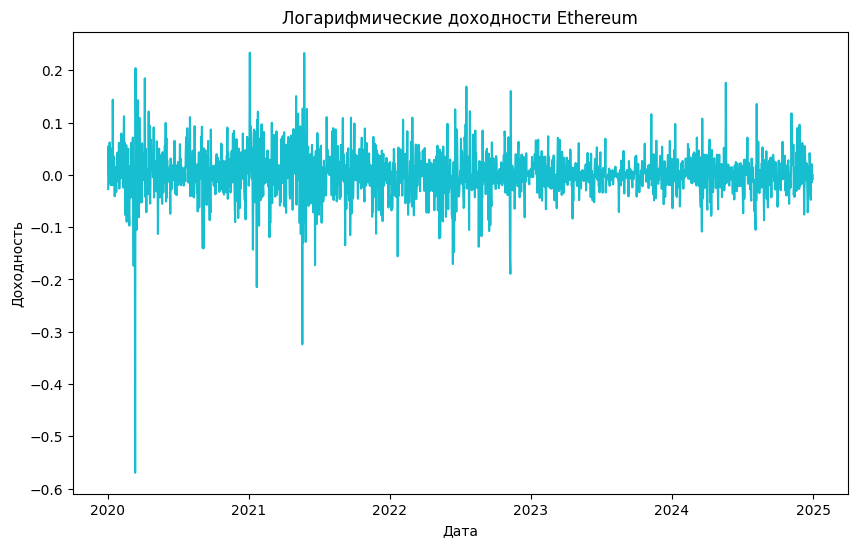

In [213]:
# Загрузка данных (например, цены закрытия Ethereum)
data = pd.read_csv('ETH_historical_prices.csv', parse_dates=['Date'], index_col='Date')
data = data.sort_index()

# Вычисление логарифмических доходностей
data['Log_Returns'] = np.log(data['Price']).diff()

# Удаление пропущенных значений (первое значение будет NaN)
data = data.dropna()

# Визуализация логарифмических доходностей
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Log_Returns'], color='tab:cyan')
plt.title('Логарифмические доходности Ethereum')
plt.xlabel('Дата')
plt.ylabel('Доходность')
plt.show()

In [214]:
# Проверка стационарности с помощью теста Дики-Фуллера
adf_test = adfuller(data['Log_Returns'])
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])

if adf_test[1] < 0.05:
    print("Временной ряд стационарен")
else:
    print("Временной ряд нестационарен")

ADF Statistic: -12.883060407342679
p-value: 4.6150246821505974e-24
Временной ряд стационарен


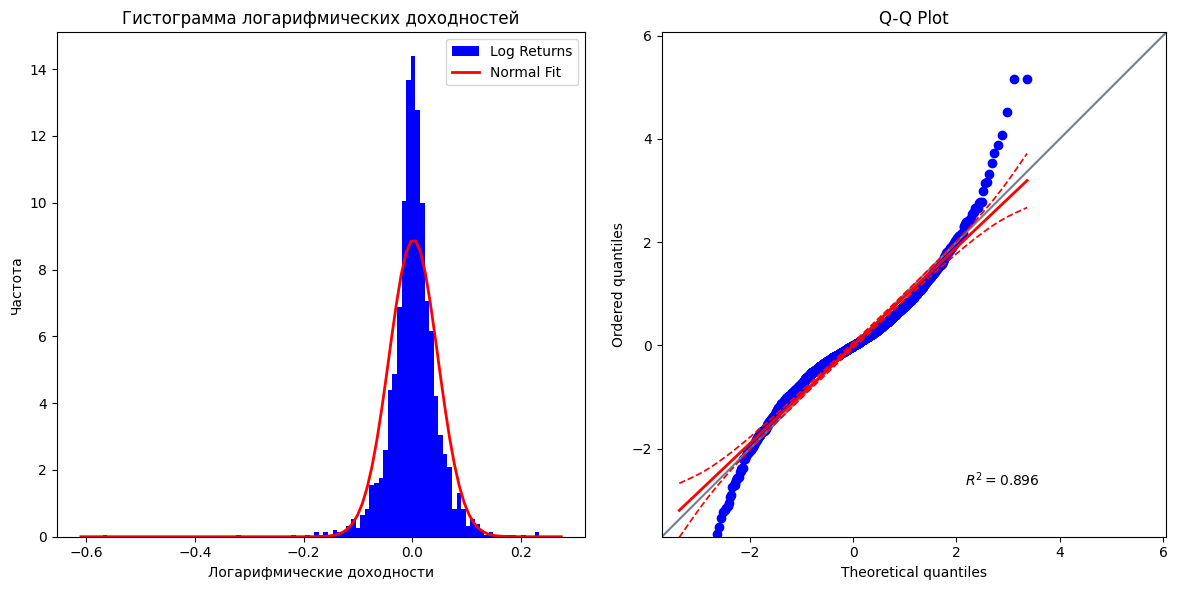

In [215]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import pingouin as pg

# Построение гистограммы и графика Q-Q
plt.figure(figsize=(12, 6))

# Гистограмма
plt.subplot(121)
plt.hist(data['Log_Returns'], bins=95, density=True, color='blue', label='Log Returns')
plt.title('Гистограмма логарифмических доходностей')
plt.xlabel('Логарифмические доходности')
plt.ylabel('Частота')

# Наложение кривой нормального распределения
mean, std = data['Log_Returns'].mean(), data['Log_Returns'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal Fit')

plt.legend()

# График Q-Q
plt.subplot(122)
pg.qqplot(x=data['Log_Returns'])
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

In [216]:
from scipy.stats import shapiro, kstest

# Тест Шапиро-Уилка
shapiro_test = shapiro(data['Log_Returns'])
print("Тест Шапиро-Уилка:")
print(f"Статистика: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")
if shapiro_test.pvalue < 0.05:
    print("Отклоняем гипотезу о нормальности.")
else:
    print("Нет оснований отклонять гипотезу о нормальности.")

# Тест Колмогорова-Смирнова
ks_test = kstest(data['Log_Returns'], 'norm', args=(data['Log_Returns'].mean(), data['Log_Returns'].std()))
print("\nТест Колмогорова-Смирнова:")
print(f"Статистика: {ks_test.statistic}, p-value: {ks_test.pvalue}")
if ks_test.pvalue < 0.05:
    print("Отклоняем гипотезу о нормальности.")
else:
    print("Нет оснований отклонять гипотезу о нормальности.")

Тест Шапиро-Уилка:
Статистика: 0.8997403383255005, p-value: 5.621366432555801e-33
Отклоняем гипотезу о нормальности.

Тест Колмогорова-Смирнова:
Статистика: 0.08870434070286207, p-value: 5.959053885598595e-13
Отклоняем гипотезу о нормальности.


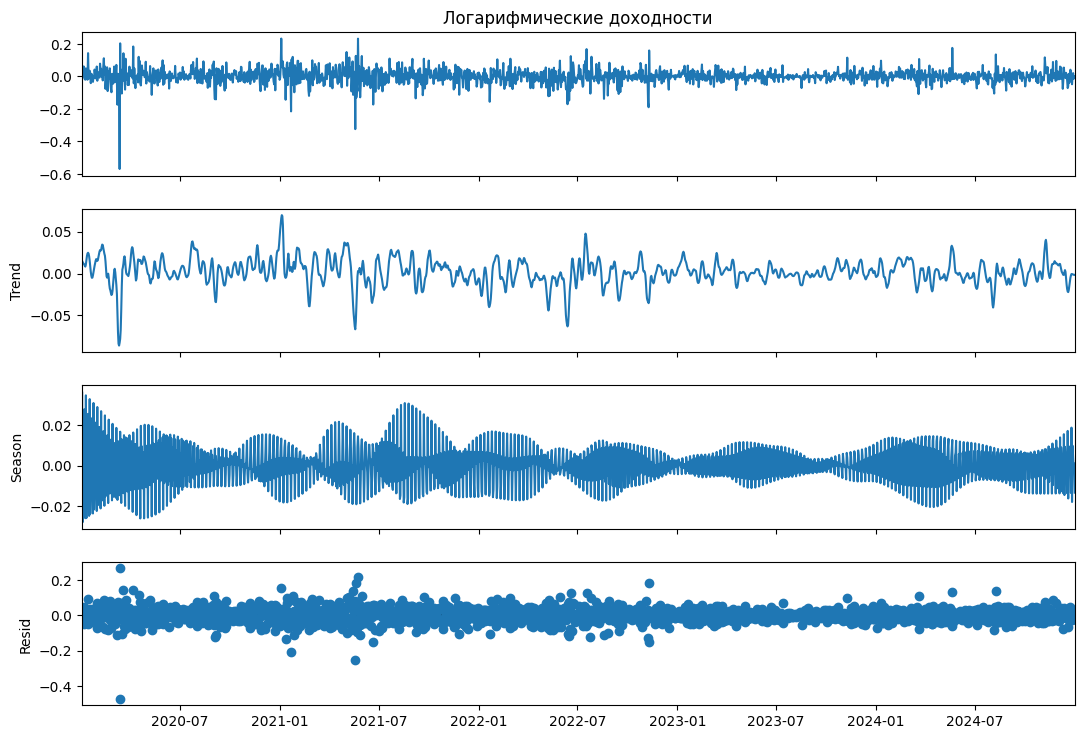

In [217]:
from statsmodels.tsa.seasonal import STL

stl = STL(data.rename(columns={'Log_Returns': 'Логарифмические доходности'})['Логарифмические доходности'], seasonal=31)
result = stl.fit()

# Получение компонент
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Отображение графика с увеличенным размером
result.plot().set_size_inches(12, 8) # Устанавливаем размер графика
plt.show()

In [218]:
# Тест Льюнга-Бокса
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(data['Log_Returns']**2, return_df=True)
print(lb_test)

      lb_stat     lb_pvalue
1   26.122869  3.203670e-07
2   30.290802  2.645062e-07
3   31.239449  7.568684e-07
4   53.853561  5.647663e-11
5   59.614623  1.460036e-11
6   60.668957  3.291246e-11
7   69.247408  2.096694e-12
8   69.315512  6.724828e-12
9   69.698053  1.745035e-11
10  71.915673  1.889293e-11


### Методы математической статистики

Подбор лучших компонент (GARCH)

In [219]:
# Определение параметров p и q с использованием информационных критериев
from arch import arch_model

# Будем тестировать различные комбинации p и q (например, от 0 до 3)
best_aic = np.inf
best_bic = np.inf
best_model = None

for p in range(4):  # Тестируем p от 0 до 3
    for q in range(4):  # Тестируем q от 0 до 3
        try:
            model = arch_model(y=data['Log_Returns'] * 10, mean='Constant', vol='GARCH', p=p, q=q, dist='t')
            result = model.fit(disp='off')
            aic = result.aic
            bic = result.bic
            
            if aic < best_aic:
                best_aic = aic
                best_model = result
                best_pq = (p, q)
            
            print(f"p={p}, q={q}: AIC={aic:.2f}, BIC={bic:.2f}")
        except:
            continue

print(f"\nЛучшая модель: p={best_pq[0]}, q={best_pq[1]} с AIC={best_aic:.2f}")

p=1, q=0: AIC=1752.88, BIC=1774.92
p=1, q=1: AIC=1614.10, BIC=1641.65
p=1, q=2: AIC=1615.13, BIC=1648.19
p=1, q=3: AIC=1615.65, BIC=1654.22
p=2, q=0: AIC=1721.94, BIC=1749.49
p=2, q=1: AIC=1616.10, BIC=1649.16
p=2, q=2: AIC=1617.13, BIC=1655.70
p=2, q=3: AIC=1617.12, BIC=1661.20
p=3, q=0: AIC=1699.15, BIC=1732.21
p=3, q=1: AIC=1618.10, BIC=1656.67
p=3, q=2: AIC=1619.62, BIC=1663.70
p=3, q=3: AIC=1619.12, BIC=1668.71

Лучшая модель: p=1, q=1 с AIC=1614.10


Построение модели (GARCH)

In [220]:
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox

# Предположим, что у нас есть логарифмические доходности в столбце 'Log_Returns'
# Построение базовой модели GARCH(1,1)
basic_garch = arch_model(y=data['Log_Returns'] * 10, mean='Constant', vol='GARCH', p=1, q=1, dist='t')
garch_result = basic_garch.fit(disp='off')  # disp='off' отключает вывод процесса оптимизации

# Вывод результатов модели
print(garch_result.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                  Log_Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -802.050
Distribution:      Standardized Student's t   AIC:                           1614.10
Method:                  Maximum Likelihood   BIC:                           1641.65
                                              No. Observations:                 1826
Date:                      Sat, Apr 19 2025   Df Residuals:                     1825
Time:                              00:18:32   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

Подбор лучших компонент (EGARCH)

In [221]:
# Определение параметров p и q с использованием информационных критериев
from arch import arch_model

# Будем тестировать различные комбинации p и q (например, от 0 до 3)
best_aic = np.inf
best_bic = np.inf
best_model = None

for p in range(4):  # Тестируем p от 0 до 3
    for q in range(4):  # Тестируем q от 0 до 3
        try:
            model = arch_model(y=data['Log_Returns'] * 10, mean='Constant', vol='EGARCH', p=p, q=q, dist='t')
            result = model.fit(disp='off')
            aic = result.aic
            bic = result.bic
            
            if aic < best_aic:
                best_aic = aic
                best_model = result
                best_pq = (p, q)
            
            print(f"p={p}, q={q}: AIC={aic:.2f}, BIC={bic:.2f}")
        except:
            continue

print(f"\nЛучшая модель: p={best_pq[0]}, q={best_pq[1]} с AIC={best_aic:.2f}")

p=1, q=0: AIC=1755.62, BIC=1777.66
p=1, q=1: AIC=1592.56, BIC=1620.11
p=1, q=2: AIC=1591.74, BIC=1624.80
p=1, q=3: AIC=1590.65, BIC=1629.22
p=2, q=0: AIC=1733.11, BIC=1760.66
p=2, q=1: AIC=1589.03, BIC=1622.09
p=2, q=2: AIC=1591.03, BIC=1629.60
p=2, q=3: AIC=1591.75, BIC=1635.83
p=3, q=0: AIC=1717.56, BIC=1750.62
p=3, q=1: AIC=1590.17, BIC=1628.74
p=3, q=2: AIC=1591.90, BIC=1635.98
p=3, q=3: AIC=1593.38, BIC=1642.96

Лучшая модель: p=2, q=1 с AIC=1589.03


Построение модели (EGARCH)

In [222]:
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox

# Предположим, что у нас есть логарифмические доходности в столбце 'Log_Returns'
# Построение базовой модели GARCH(1,1)
basic_egarch = arch_model(y=data['Log_Returns'] * 10, mean='Constant', vol='EGARCH', p=2, q=1, dist='t')
egarch_result = basic_egarch.fit(disp='off')  # disp='off' отключает вывод процесса оптимизации

# Вывод результатов модели
print(egarch_result.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                  Log_Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -788.517
Distribution:      Standardized Student's t   AIC:                           1589.03
Method:                  Maximum Likelihood   BIC:                           1622.09
                                              No. Observations:                 1826
Date:                      Sat, Apr 19 2025   Df Residuals:                     1825
Time:                              00:18:32   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

Разные временные окна

In [223]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

data_test = data.copy()

# Создаем списки для хранения результатов
results = []

for window in range(3, 31):

    data_test['Historical_Volatility'] = data_test['Log_Returns'].rolling(window=window).std()
    data_test['GARCH_Volatility'] = garch_result.conditional_volatility
    data_test['EGARCH_Volatility'] = egarch_result.conditional_volatility

    # Создаем дополнительный датафрейм
    data_example = data_test.reset_index()

    # Удаляем NaN (первые `window-1` значений скользящей волатильности)
    rolling_vol_valid = data_test['Historical_Volatility'].dropna()
    conditional_vol_valid_garch = data_example[data_example['Date'] >= (pd.to_datetime('2020-01-01') + pd.Timedelta(days=window))]['GARCH_Volatility'] / 10
    conditional_vol_valid_egarch = data_example[data_example['Date'] >= (pd.to_datetime('2020-01-01') + pd.Timedelta(days=window))]['EGARCH_Volatility'] / 10

    # Расчет метрик
    metrics = {
        'Window': window,
        'GARCH_RMSE': np.sqrt(mean_squared_error(rolling_vol_valid, conditional_vol_valid_garch)),
        'EGARCH_RMSE': np.sqrt(mean_squared_error(rolling_vol_valid, conditional_vol_valid_egarch)),
        'GARCH_R2': r2_score(rolling_vol_valid, conditional_vol_valid_garch),
        'EGARCH_R2': r2_score(rolling_vol_valid, conditional_vol_valid_egarch),
        'GARCH_MAE': mean_absolute_error(rolling_vol_valid, conditional_vol_valid_garch),
        'EGARCH_MAE': mean_absolute_error(rolling_vol_valid, conditional_vol_valid_egarch),
        'GARCH_MAPE': mean_absolute_percentage_error(rolling_vol_valid, conditional_vol_valid_garch),
        'EGARCH_MAPE': mean_absolute_percentage_error(rolling_vol_valid, conditional_vol_valid_egarch)
    }
    results.append(metrics)

    # Создаем DataFrame из результатов
    results_df = pd.DataFrame(results)

    # Формируем столбцы для финального сравнения
    results_df['RMSE'] = results_df.apply(
        lambda row: 'GARCH' if row['GARCH_RMSE'] < row['EGARCH_RMSE'] else 'EGARCH', axis=1)
    results_df['R2'] = results_df.apply(
        lambda row: 'GARCH' if row['GARCH_R2'] > row['EGARCH_R2'] else 'EGARCH', axis=1)
    results_df['MAE'] = results_df.apply(
        lambda row: 'GARCH' if row['GARCH_MAE'] < row['EGARCH_MAE'] else 'EGARCH', axis=1)
    results_df['MAPE'] = results_df.apply(
        lambda row: 'GARCH' if row['GARCH_MAPE'] < row['EGARCH_MAPE'] else 'EGARCH', axis=1)

results_df

,Window,GARCH_RMSE,EGARCH_RMSE,GARCH_R2,EGARCH_R2,GARCH_MAE,EGARCH_MAE,GARCH_MAPE,EGARCH_MAPE,RMSE,R2,MAE,MAPE
0,3,0.024947,0.024219,0.260174,0.302744,0.018272,0.017704,1.177454,1.126584,EGARCH,EGARCH,EGARCH,EGARCH
1,4,0.020835,0.020904,0.398771,0.394788,0.015040,0.014941,0.757339,0.729690,GARCH,GARCH,EGARCH,EGARCH
2,5,0.018183,0.018762,0.486533,0.453328,0.013037,0.013313,0.583465,0.570112,GARCH,GARCH,GARCH,EGARCH
3,6,0.016230,0.017221,0.559455,0.504025,0.011535,0.012069,0.474812,0.471592,GARCH,GARCH,GARCH,EGARCH
4,7,0.014752,0.016096,0.614354,0.540856,0.010420,0.011202,0.407205,0.411297,GARCH,GARCH,GARCH,GARCH
5,8,0.013647,0.015302,0.656246,0.567821,0.009657,0.010564,0.364272,0.372542,GARCH,GARCH,GARCH,GARCH
6,9,0.012621,0.014475,0.695469,0.599425,0.008976,0.009976,0.329806,0.340928,GARCH,GARCH,GARCH,GARCH
7,10,0.011696,0.013819,0.729890,0.622909,0.008383,0.009504,0.302444,0.316411,GARCH,GARCH,GARCH,GARCH
8,11,0.011000,0.013315,0.753930,0.639409,0.007933,0.009150,0.281776,0.297585,GARCH,GARCH,GARCH,GARCH
9,12,0.010407,0.012806,0.774055,0.657893,0.007550,0.008802,0.264171,0.280500,GARCH,GARCH,GARCH,GARCH


Сравнительная визуализация моделей с исходными логарифмическими доходностями с окном 20 дней

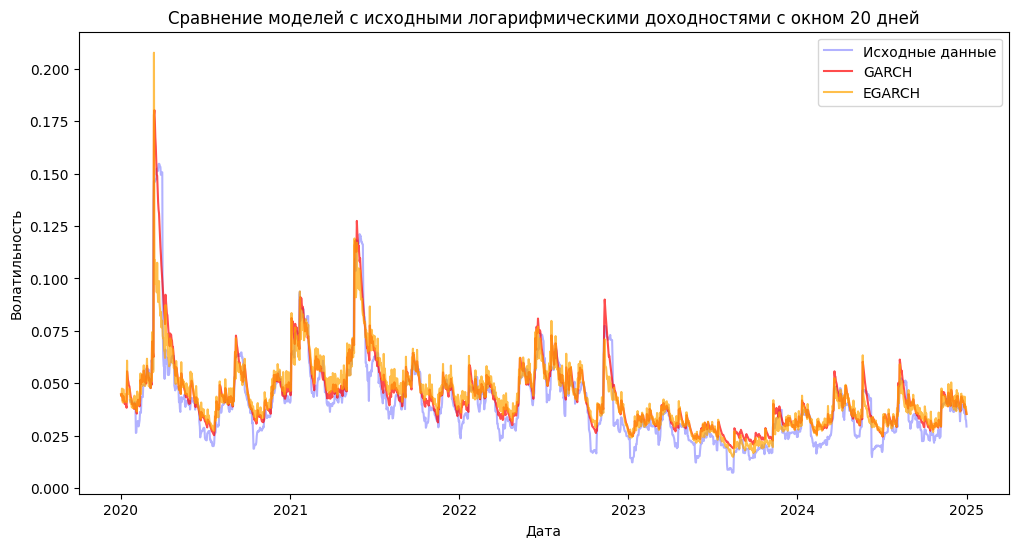

In [224]:
# Рассчитываем исходную волатильность с окном 20 дней
window = 20
data['Historical_Volatility'] = data['Log_Returns'].rolling(window=window).std()

# Условная волатильность из модели GARCH
data['GARCH_Volatility'] = garch_result.conditional_volatility

# Условная волатильность из модели EGARCH
data['EGARCH_Volatility'] = egarch_result.conditional_volatility

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Historical_Volatility'], label='Исходные данные', color='blue', alpha=0.3)
plt.plot(data.index, data['GARCH_Volatility'] / 10, label='GARCH', color='red', alpha=0.7)
plt.plot(data.index, data['EGARCH_Volatility'] / 10, label='EGARCH', color='orange', alpha=0.7)
plt.title('Сравнение моделей с исходными логарифмическими доходностями c окном 20 дней')
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.show()

Количественная оценка моделей

In [225]:
from sklearn.metrics import mean_squared_error, r2_score

# Создаем дополнительный датафрейм
data_example = data.reset_index()

# Удаляем NaN (первые `window-1` значений скользящей волатильности)
rolling_vol_valid = data['Historical_Volatility'].dropna()
conditional_vol_valid_garch = data_example[data_example['Date'] >= pd.to_datetime('2020-01-21')]['GARCH_Volatility'] / 10
conditional_vol_valid_egarch = data_example[data_example['Date'] >= pd.to_datetime('2020-01-21')]['EGARCH_Volatility'] / 10

# Считаем метрики GARCH
rmse_garch = np.sqrt(mean_squared_error(rolling_vol_valid, conditional_vol_valid_garch))
r2_garch = r2_score(rolling_vol_valid, conditional_vol_valid_garch)
mae_garch = mean_absolute_error(rolling_vol_valid, conditional_vol_valid_garch)
mape_garch = mean_absolute_percentage_error(rolling_vol_valid, conditional_vol_valid_garch)

# Считаем метрики EGARCH
rmse_egarch = np.sqrt(mean_squared_error(rolling_vol_valid, conditional_vol_valid_egarch))
r2_egarch = r2_score(rolling_vol_valid, conditional_vol_valid_egarch)
mae_egarch = mean_absolute_error(rolling_vol_valid, conditional_vol_valid_egarch)
mape_egarch = mean_absolute_percentage_error(rolling_vol_valid, conditional_vol_valid_egarch)

print('GARCH & EGARCH')
print(f"RMSE: {rmse_garch:.4f} | {rmse_egarch:.4f}")
print(f"R²: {r2_garch:.4f} | {r2_egarch:.4f}")
print(f"MAE: {mae_garch:.4f} | {mae_egarch:.4f}")
print(f"MAPE: {mape_garch:.4f} | {mape_egarch:.4f}")

GARCH & EGARCH
RMSE: 0.0079 | 0.0103
R²: 0.8492 | 0.7441
MAE: 0.0060 | 0.0071
MAPE: 0.1900 | 0.2036


Сравнительная визуализация моделей с исходными логарифмическими доходностями с окном 30 дней

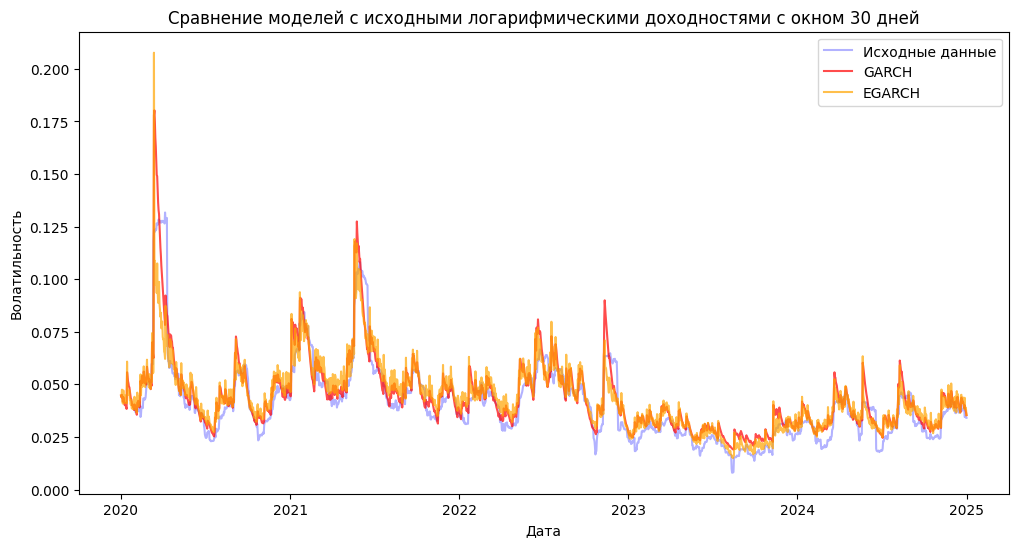

In [226]:
# Рассчитываем исходную волатильность с окном 30 дней
window = 30
data['Historical_Volatility'] = data['Log_Returns'].rolling(window=window).std()

# Условная волатильность из модели GARCH
data['GARCH_Volatility'] = garch_result.conditional_volatility

# Условная волатильность из модели EGARCH
data['EGARCH_Volatility'] = egarch_result.conditional_volatility

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Historical_Volatility'], label='Исходные данные', color='blue', alpha=0.3)
plt.plot(data.index, data['GARCH_Volatility'] / 10, label='GARCH', color='red', alpha=0.7)
plt.plot(data.index, data['EGARCH_Volatility'] / 10, label='EGARCH', color='orange', alpha=0.7)
plt.title('Сравнение моделей с исходными логарифмическими доходностями c окном 30 дней')
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.show()

Количественная оценка моделей

In [227]:
from sklearn.metrics import mean_squared_error, r2_score

# Создаем дополнительный датафрейм
data_example = data.reset_index()

# Удаляем NaN (первые `window-1` значений скользящей волатильности)
rolling_vol_valid = data['Historical_Volatility'].dropna()
conditional_vol_valid_garch = data_example[data_example['Date'] >= pd.to_datetime('2020-01-31')]['GARCH_Volatility'] / 10
conditional_vol_valid_egarch = data_example[data_example['Date'] >= pd.to_datetime('2020-01-31')]['EGARCH_Volatility'] / 10

# Считаем метрики GARCH
rmse_garch = np.sqrt(mean_squared_error(rolling_vol_valid, conditional_vol_valid_garch))
r2_garch = r2_score(rolling_vol_valid, conditional_vol_valid_garch)
mae_garch = mean_absolute_error(rolling_vol_valid, conditional_vol_valid_garch)
mape_garch = mean_absolute_percentage_error(rolling_vol_valid, conditional_vol_valid_garch)

# Считаем метрики EGARCH
rmse_egarch = np.sqrt(mean_squared_error(rolling_vol_valid, conditional_vol_valid_egarch))
r2_egarch = r2_score(rolling_vol_valid, conditional_vol_valid_egarch)
mae_egarch = mean_absolute_error(rolling_vol_valid, conditional_vol_valid_egarch)
mape_egarch = mean_absolute_percentage_error(rolling_vol_valid, conditional_vol_valid_egarch)

print('GARCH & EGARCH')
print(f"RMSE: {rmse_garch:.4f} | {rmse_egarch:.4f}")
print(f"R²: {r2_garch:.4f} | {r2_egarch:.4f}")
print(f"MAE: {mae_garch:.4f} | {mae_egarch:.4f}")
print(f"MAPE: {mape_garch:.4f} | {mape_egarch:.4f}")

GARCH & EGARCH
RMSE: 0.0084 | 0.0093
R²: 0.8088 | 0.7611
MAE: 0.0061 | 0.0063
MAPE: 0.1679 | 0.1665


Проверка остатков моделей на автокорреляцию

In [228]:
from statsmodels.stats.diagnostic import acorr_ljungbox

std_resid = garch_result.resid / garch_result.conditional_volatility
lb_test = round(acorr_ljungbox(std_resid, lags=[10]), 2)
print(lb_test.lb_pvalue)

10    0.07
Name: lb_pvalue, dtype: float64


In [229]:
std_resid = egarch_result.resid / egarch_result.conditional_volatility
lb_test = round(acorr_ljungbox(std_resid, lags=[10]), 2)
print(lb_test.lb_pvalue)

10    0.05
Name: lb_pvalue, dtype: float64


Прогнозирование волатильности

In [230]:
# Прогноз на 30 дней вперёд

forecasts_garch = garch_result.forecast(horizon=30, reindex=False)
conditional_volatility_garch = np.sqrt(forecasts_garch.variance.iloc[-1]) / 10

forecasts_egarch = egarch_result.forecast(horizon=30, reindex=False, method='bootstrap')
conditional_volatility_egarch = np.sqrt(forecasts_egarch.variance.iloc[-1]) / 10

In [231]:
from datetime import datetime, timedelta

# Начальная дата
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 1, 30)

date_list = []
current_date = start_date

while current_date <= end_date:
    date_list.append(current_date.strftime('%Y-%m-%d'))  # Форматируем дату как строку
    current_date += timedelta(days=1)  # Увеличиваем дату на один день

forecast_data = pd.DataFrame({'Date': date_list, 'GARCH': conditional_volatility_garch, 'EGARCH': conditional_volatility_egarch})
forecast_data['Date'] = pd.to_datetime(forecast_data['Date'])
forecast_data.set_index('Date', inplace=True)

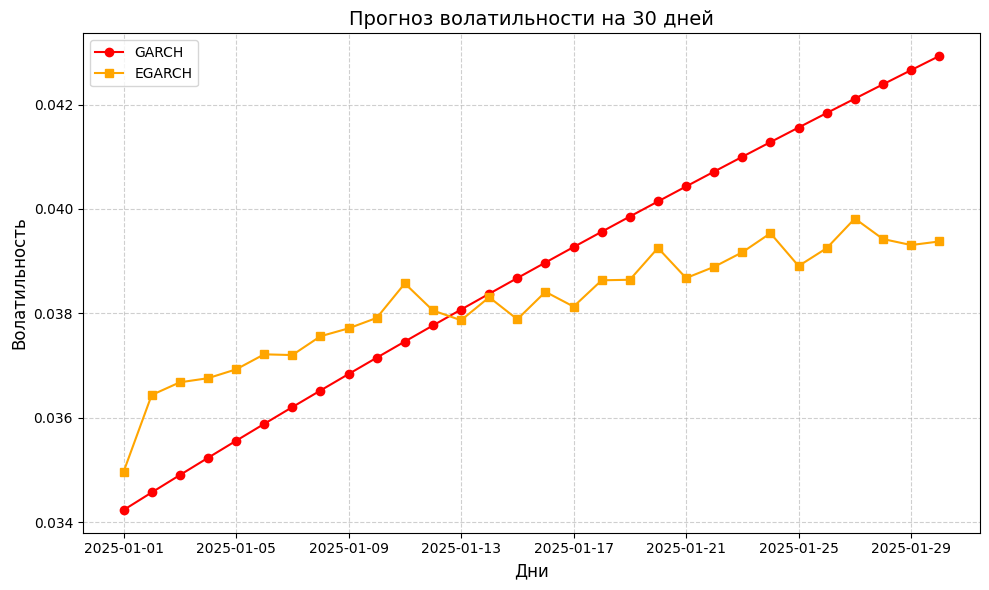

In [232]:
# Создание графика
plt.figure(figsize=(10, 6))  # Размер графика

# Построение линий
plt.plot(forecast_data['GARCH'], color='red', marker='o', label='GARCH')
plt.plot(forecast_data['EGARCH'], color='orange', marker='s', label='EGARCH')

# Настройка осей
plt.xlabel('Дни', fontsize=12)
plt.ylabel('Волатильность', fontsize=12)
plt.title('Прогноз волатильности на 30 дней', fontsize=14)

# Добавление легенды
plt.legend(fontsize=10)

# Настройка сетки
plt.grid(True, linestyle='--', alpha=0.6)

# Сохранение или отображение графика
plt.tight_layout()  # Автоматическое выравнивание компонентов графика
plt.show()

Сравнение прогноза с реальными данными

In [233]:
# Вычисление логарифмических доходностей
df_test['Log_Returns'] = np.log(df_test['Price']).diff()

# Удаление пропущенных значений (первое значение будет NaN)
df_test = df_test.dropna()

# Определение волатильности
df_test['Historical_Volatility'] = df_test['Log_Returns'].rolling(window=30).std()

# Удаление пропущенных значений
df_test.dropna(inplace=True)

# Изменение индекса
df_test.set_index('Date', inplace=True)

C:\Users\Anatoly\AppData\Local\Temp\ipykernel_9248\638084861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Log_Returns'] = np.log(df_test['Price']).diff()


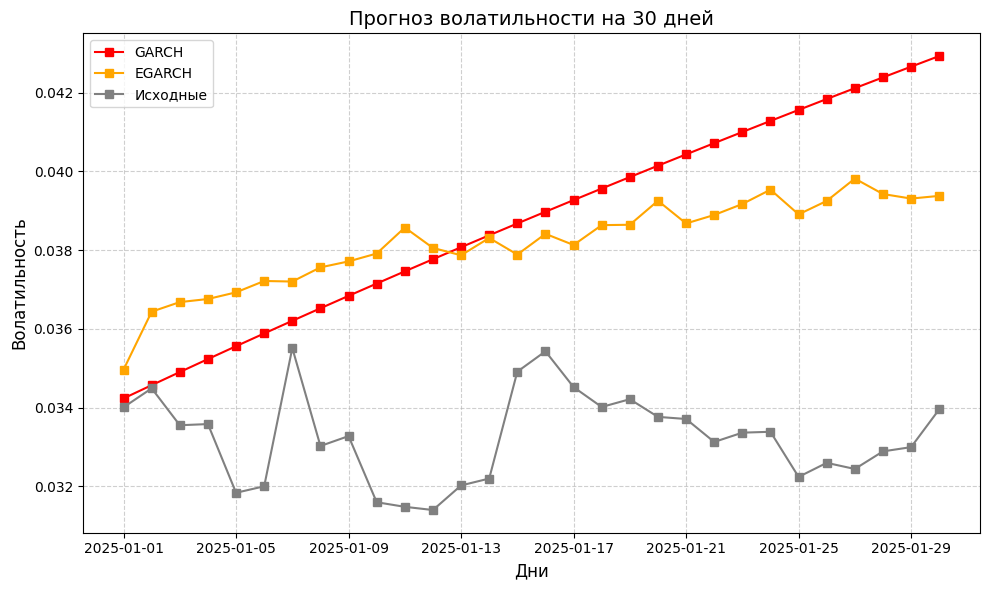

In [234]:
# Создание графика
plt.figure(figsize=(10, 6))  # Размер графика

# Построение линий
plt.plot(forecast_data['GARCH'], color='red', marker='s', label='GARCH')
plt.plot(forecast_data['EGARCH'], color='orange', marker='s', label='EGARCH')
plt.plot(df_test['Historical_Volatility'], color='gray', marker='s', label='Исходные')

# Настройка осей
plt.xlabel('Дни', fontsize=12)
plt.ylabel('Волатильность', fontsize=12)
plt.title('Прогноз волатильности на 30 дней', fontsize=14)

# Добавление легенды
plt.legend(fontsize=10)

# Настройка сетки
plt.grid(True, linestyle='--', alpha=0.6)

# Сохранение или отображение графика
plt.tight_layout()  # Автоматическое выравнивание компонентов графика
plt.show()

Импортируем библиотеки

In [235]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

RNN

Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1294 - mae: 0.2734 - val_loss: 0.0032 - val_mae: 0.0517
Epoch 2/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0332 - mae: 0.1366 - val_loss: 0.0017 - val_mae: 0.0352
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0203 - mae: 0.1069 - val_loss: 5.0155e-04 - val_mae: 0.0175
Epoch 4/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0127 - mae: 0.0863 - val_loss: 3.6342e-04 - val_mae: 0.0148
Epoch 5/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0123 - mae: 0.0780 - val_loss: 2.8044e-04 - val_mae: 0.0125
Epoch 6/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0101 - mae: 0.0731 - val_loss: 2.0826e-04 - val_mae: 0.0101
Epoch 7/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0626 - val_loss: 3.7802e-04 - val_mae: 0.0154
Epoch 8/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0647 - val_loss: 4.9713e-04 - val_mae: 0.0193
Epoch 9/100
142/142 ━━━

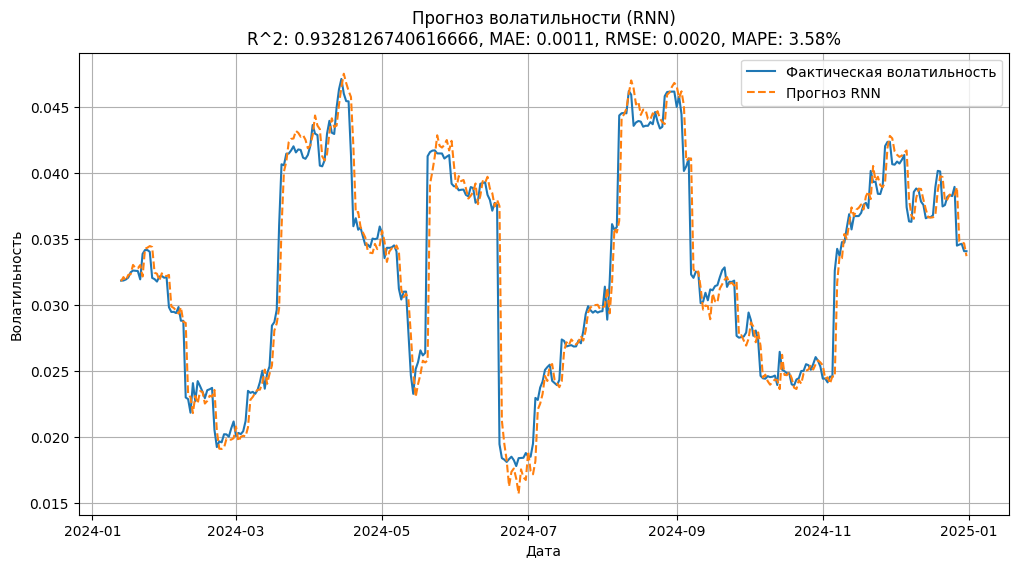

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

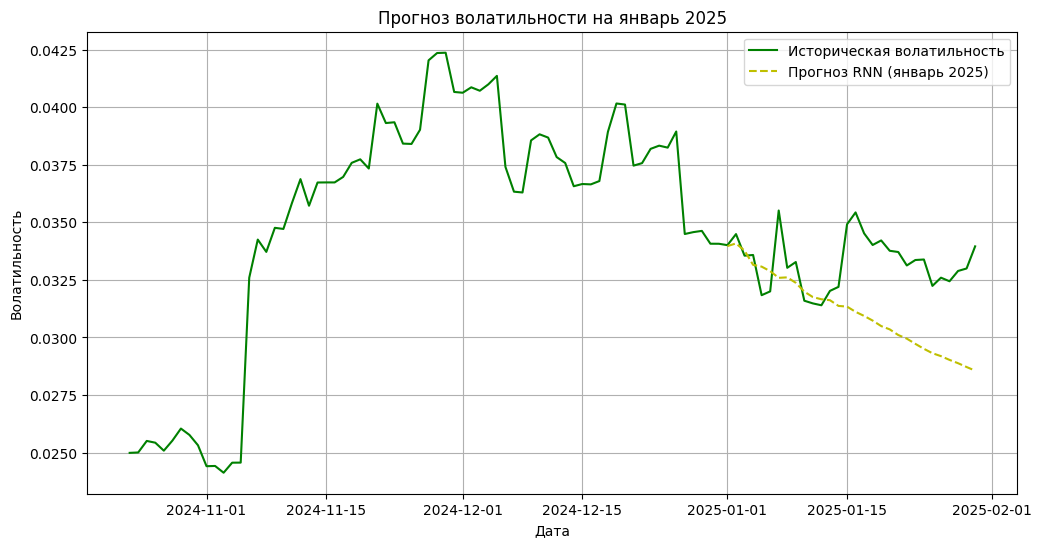

In [236]:
# Нормализация данных (масштабирование к [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Historical_Volatility']].dropna().values)

# Подготовка данных для RNN (X = предыдущие значения, y = следующее значение)
def create_dataset(data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 30  # Используем 10 предыдущих дней для прогноза
X, y = create_dataset(scaled_data, look_back)

# Разделение на обучающую и тестовую выборки (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape для RNN: [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Создание модели RNN
model = Sequential([
    SimpleRNN(units=50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.3),
    SimpleRNN(units=50),
    Dropout(0.3),
    Dense(units=1)
])

# Компиляция модели
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Обучение
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mean_squared_error',  # Менее чувствительна к выбросам чем MSE
    metrics=['mae']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Прогнозирование на тестовой выборке
y_pred = model.predict(X_test)

# Обратное масштабирование данных
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

# Оценка модели
r2 = r2_score(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100  # В процентах

print(f"\nОценка модели RNN:")
print(f"- R^2: {r2:.6f}")
print(f"- MAE: {mae:.6f}")
print(f"- RMSE: {rmse:.6f}")
print(f"- MAPE: {mape:.2f}%")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_actual, label='Фактическая волатильность')
plt.plot(data.index[-len(y_test):], y_pred_actual, label='Прогноз RNN', linestyle='--')
plt.title(f"Прогноз волатильности (RNN)\nR^2: {r2}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.grid()
plt.show()

# Прогноз на 30 дней вперед (январь 2025)
def forecast_future(model, initial_sequence, steps=30, noise_level=0.005):
    future_predictions = []
    current_sequence = initial_sequence.copy()
    
    for _ in range(steps):
        next_pred = model.predict(current_sequence.reshape(1, look_back, 1))
        future_predictions.append(next_pred)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
    
    return future_predictions

# Берем последние `look_back` значений для прогноза
last_sequence = scaled_data[-look_back:]
future_volatility_scaled = forecast_future(model, last_sequence, steps=30)
future_volatility = scaler.inverse_transform(np.array(future_volatility_scaled).reshape(-1, 1))

# Даты для будущего прогноза
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Формирование единого датасета
union_data = pd.concat([data[['Price', 'Log_Returns', 'Historical_Volatility']], df_test])

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(union_data.index[-100:], union_data[['Historical_Volatility']].dropna().values[-100:], label='Историческая волатильность', color='g')
plt.plot(future_dates, future_volatility, '--y', label='Прогноз RNN (январь 2025)')
plt.title('Прогноз волатильности на январь 2025')
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.grid()
plt.show()


Fold 1

Training samples: 444, Validation samples: 441
Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0863 - val_loss: 0.0046
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0148 - val_loss: 9.5280e-04
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - val_loss: 0.0010
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0116 - val_loss: 9.3300e-04
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - val_loss: 7.2377e-04
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - val_loss: 0.0011
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_loss: 6.6404e-04
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - val_loss: 7.8788e-04
Epoch 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - val_loss: 9.1774e-04
Epoch 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - val_loss: 6.0329e-04
Epoch 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - val_lo

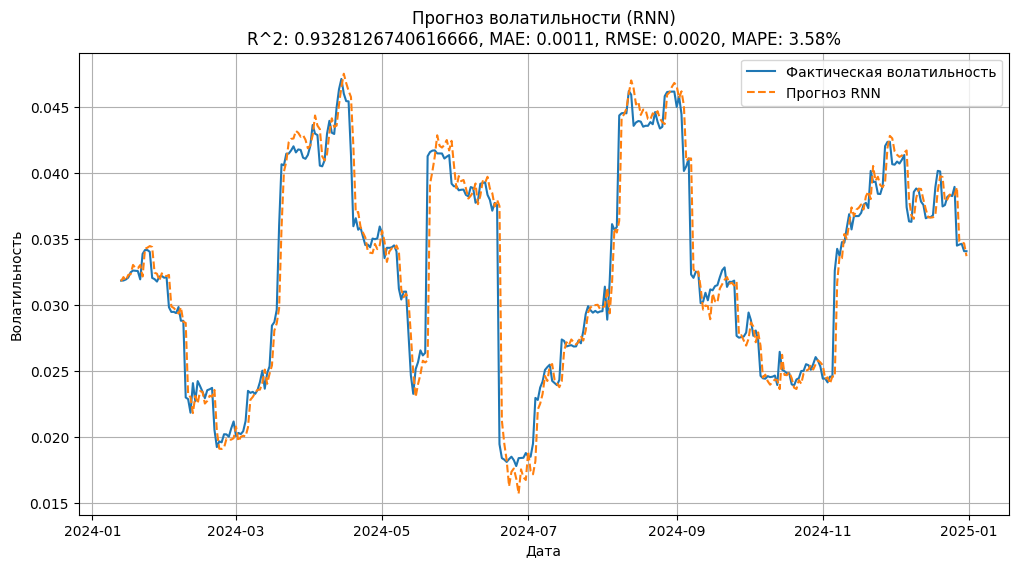

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━

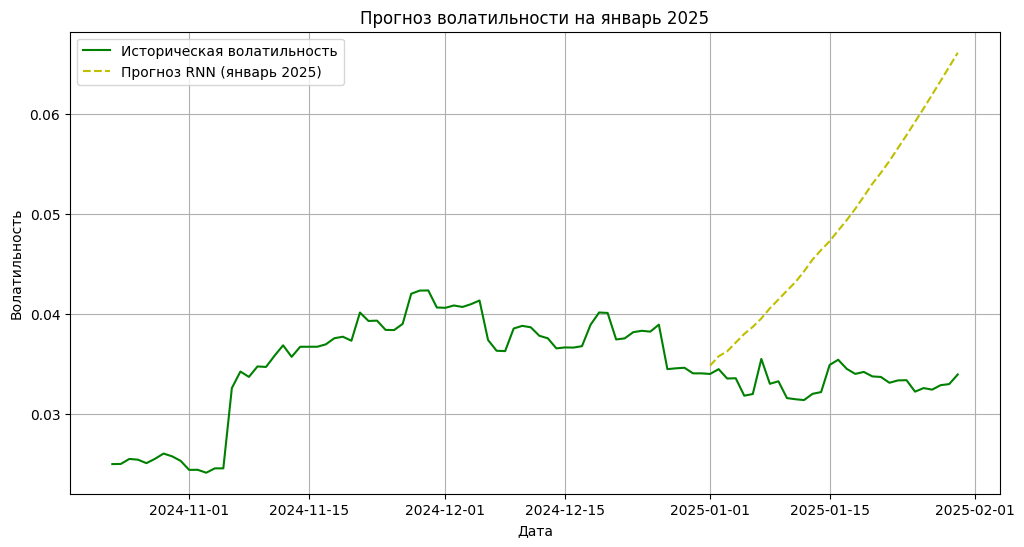

In [237]:
# Нормализация данных (масштабирование к [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Historical_Volatility']].dropna().values)

# Подготовка данных для RNN (X = предыдущие значения, y = следующее значение)
def create_dataset(data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 30  # Используем 30 предыдущих дней для прогноза
X, y = create_dataset(scaled_data, look_back)

# Разделение на обучающую и тестовую выборки (80/20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 2. Кросс-валидация TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
fold_scores = []

for fold, (train_index, val_index) in enumerate(tscv.split(X)):
    print(f"\nFold {fold+1}")
    K.clear_session()
    
    # 3. Создание модели через Functional API
    input_layer = Input(shape=(look_back, 1), name='input_layer')
    rnn_layer = SimpleRNN(64, return_sequences=False, name='rnn_1')(input_layer)
    dropout = Dropout(0.3)(rnn_layer)
    output_layer = Dense(1, name='output')(dropout)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # 4. Обучение с проверкой размерностей
    print(f"Training samples: {len(train_index)}, Validation samples: {len(val_index)}")
    try:
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X[train_index], 
            y[train_index],
            validation_data=(X[val_index], y[val_index]),
            epochs=30,
            batch_size=16,
            verbose=1,
            callbacks=[early_stop]
        )
        
        # 5. Оценка модели
        val_pred = model.predict(X[val_index])
        val_rmse = np.sqrt(mean_squared_error(y[val_index], val_pred))
        fold_scores.append(val_rmse)
        print(f"Fold {fold+1} RMSE: {val_rmse:.6f}")
        
    except Exception as e:
        print(f"Error in fold {fold+1}: {str(e)}")
        continue

# 6. Финальное обучение на всех данных
print("\nTraining final model on full dataset...")
K.clear_session()
final_model = Model(inputs=input_layer, outputs=output_layer)
final_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
final_model.fit(X, y, epochs=30, batch_size=16, verbose=1)

# 7. Вывод результатов кросс-валидации
print("\nCross-validation results:")
for i, score in enumerate(fold_scores):
    print(f"Fold {i+1}: RMSE = {score:.6f}")
print(f"Mean RMSE: {np.mean(fold_scores):.6f}")

# Обратное масштабирование данных
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

# Оценка модели
r2 = r2_score(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual) * 100  # В процентах

print(f"\nОценка модели RNN:")
print(f"- R^2: {r2:.6f}")
print(f"- MAE: {mae:.6f}")
print(f"- RMSE: {rmse:.6f}")
print(f"- MAPE: {mape:.2f}%")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_actual, label='Фактическая волатильность')
plt.plot(data.index[-len(y_test):], y_pred_actual, label='Прогноз RNN', linestyle='--')
plt.title(f"Прогноз волатильности (RNN)\nR^2: {r2}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.grid()
plt.show()

# Прогноз на 30 дней вперед (январь 2025)
def forecast_future(final_model, initial_sequence, steps=30, noise_level=0.005):
    future_predictions = []
    current_sequence = initial_sequence.copy()
    
    for _ in range(steps):
        next_pred = final_model.predict(current_sequence.reshape(1, look_back, 1))
        future_predictions.append(next_pred)
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
    
    return future_predictions

# Берем последние `look_back` значений для прогноза
last_sequence = scaled_data[-look_back:]
future_volatility_scaled = forecast_future(final_model, last_sequence, steps=30)
future_volatility = scaler.inverse_transform(np.array(future_volatility_scaled).reshape(-1, 1))

# Даты для будущего прогноза
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Формирование единого датасета
union_data = pd.concat([data[['Price', 'Log_Returns', 'Historical_Volatility']], df_test])

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(union_data.index[-100:], union_data[['Historical_Volatility']].dropna().values[-100:], label='Историческая волатильность', color='g')
plt.plot(future_dates, future_volatility, '--y', label='Прогноз RNN (январь 2025)')
plt.title('Прогноз волатильности на январь 2025')
plt.xlabel('Дата')
plt.ylabel('Волатильность')
plt.legend()
plt.grid()
plt.show()

LSM

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0258 - val_loss: 4.4180e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064 - val_loss: 4.0864e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - val_loss: 9.7932e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - val_loss: 3.1271e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - val_loss: 2.9861e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - val_loss: 4.4131e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0035 - val_loss: 3.5816e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 6.3648e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - val_loss: 3.1517e-04
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - val_loss: 2.9245e-04
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - val_loss: 3.2207e-04
Epoch 12/50
41/41 ━━━━━━━━━

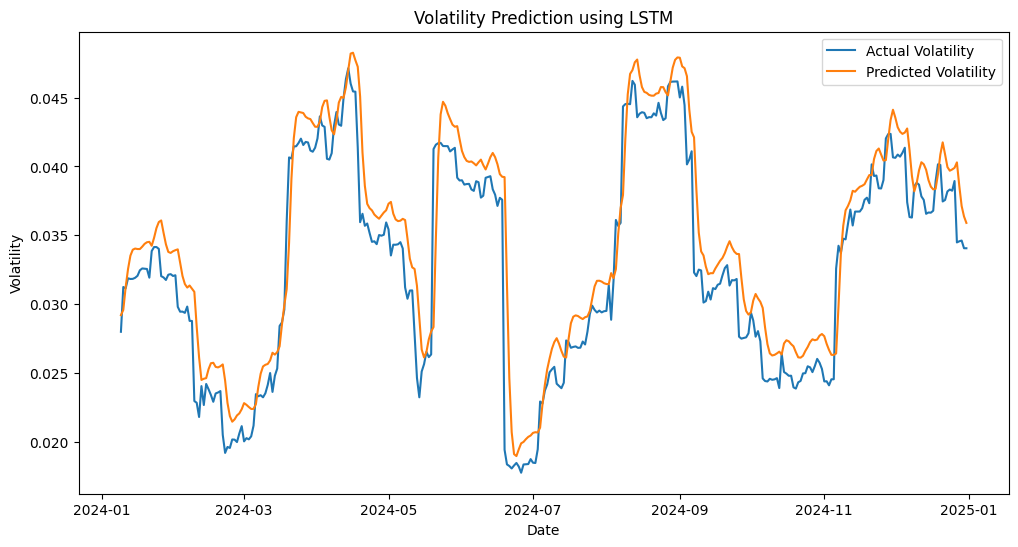

In [238]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Historical_Volatility']].dropna().values)

# Подготовка данных для LSTM
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 10 # Количество предыдущих дней для прогноза
X, y = create_dataset(scaled_data, look_back)

# Разделение на обучающую и тестовую выборки
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Преобразование данных для LSTM (формат [samples, time steps, features])
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Создание модели LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Обучение модели
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Прогнозирование
y_pred = model.predict(X_test)

# Обратное преобразование масштаба
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

# Оценка модели
mse = mean_squared_error(y_test_actual, y_pred_actual)
print(f"Mean Squared Error: {mse}")

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_actual, label='Actual Volatility')
plt.plot(data.index[-len(y_test):], y_pred_actual, label='Predicted Volatility')
plt.title('Volatility Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

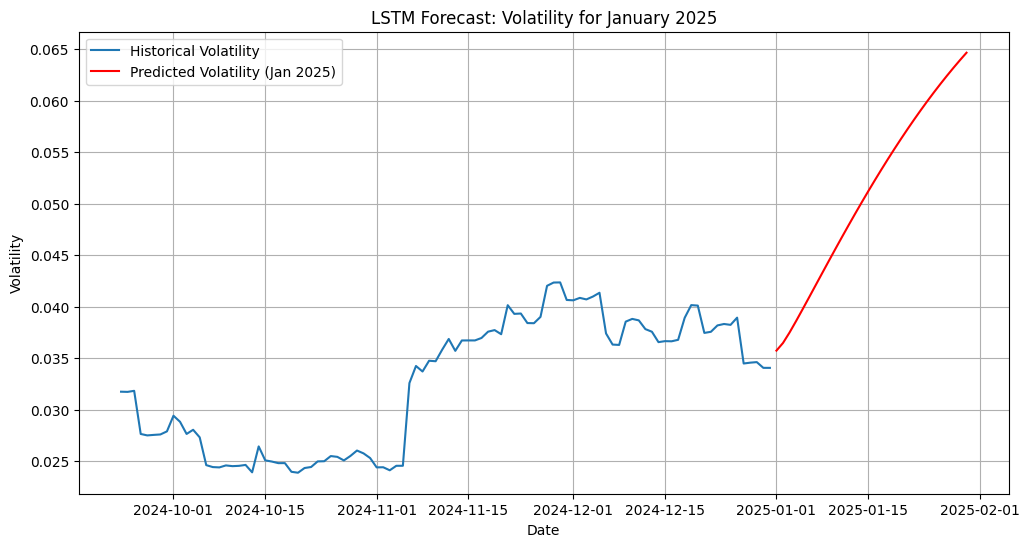

        Date  Predicted_Volatility
0 2025-01-01              0.035741
1 2025-01-02              0.036482
2 2025-01-03              0.037498
3 2025-01-04              0.038612
4 2025-01-05              0.039765
5 2025-01-06              0.040933
6 2025-01-07              0.042109
7 2025-01-08              0.043285
8 2025-01-09              0.044455
9 2025-01-10              0.045617


In [240]:
# Функция для итеративного прогнозирования
def forecast_future(model, initial_sequence, steps=30):
    future_predictions = []
    current_sequence = initial_sequence.copy()
    
    for _ in range(steps):
        # Предсказание следующего значения
        next_pred = model.predict(current_sequence.reshape(1, look_back, 1))
        future_predictions.append(next_pred[0, 0])
        
        # Обновление последовательности: удаляем первое значение и добавляем предсказанное
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred[0, 0]
    
    return future_predictions

# Последние 'look_back' значений из исходных данных (нормированные)
last_sequence = scaled_data[-look_back:]

# Прогноз на 30 дней (январь 2025)
future_volatility_scaled = forecast_future(model, last_sequence, steps=30)

# Обратное масштабирование прогнозов
future_volatility = scaler.inverse_transform(np.array(future_volatility_scaled).reshape(-1, 1))

# Создание дат для будущего периода
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(data.index[-100:], data['Historical_Volatility'].values[-100:], label='Historical Volatility')
plt.plot(future_dates, future_volatility, 'r-', label='Predicted Volatility (Jan 2025)')
plt.title('LSTM Forecast: Volatility for January 2025')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()

# Вывод прогнозируемых значений
future_volatility_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Volatility': future_volatility.flatten()
})
print(future_volatility_df.head(10))  # Первые 10 дней января